# Introduction

This my first pass at trying to check if my star parameters worked.

I used the version of star and the annotation files included in the 10x cellranger-arc archive as the closest check I could manage.

In [1]:
import scipy
import pandas
import scanpy
import numpy
from pathlib import Path
from matplotlib import pyplot
import sys

In [2]:
pwd

'/woldlab/loxcyc/home/diane/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/adrenal/ENCSR724KET_16f_nuc'

In [3]:
project_root = Path("../..").absolute()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
from common import compute_spearman_anndata

In [4]:
def scanpy_load_solo279a_mtx(analysis_dir, quantification="Gene", mode="filtered"):
    assert mode in ["filtered", "raw"], "STAR Solo only produces raw or filtered files"
    assert quantification in ["Gene", "GeneFull", "SJ"]

    analysis_dir = Path(analysis_dir)
    feature_name = "features.tsv"
    
    solo_dir = analysis_dir / "Solo.out" / quantification / mode
    solo = scanpy.read_mtx(solo_dir / "matrix.mtx").T
    solo_vars = pandas.read_csv(
        solo_dir / feature_name, header=None, sep="\t"
    ).values.T
    solo_obs = pandas.read_csv(
        solo_dir / "barcodes.tsv", header=None, sep="\t"
    ).values.T
    solo.obs_names = solo_obs[0]
    solo.var_names = solo_vars[0]

    solo.obs["counts"] = solo.X.sum(axis=1)
    solo.obs["ngenes"] = numpy.array((solo.X > 0).sum(axis=1))

    return solo



In [5]:
tenx_root = Path('ENCSR724KET_cr-arc')
tenx_raw_path = tenx_root / 'outs' / 'raw_feature_bc_matrix'
tenx_filtered_path = tenx_root / 'outs' / 'filtered_feature_bc_matrix'

In [6]:
tenx_filtered = scanpy.read_10x_mtx(tenx_filtered_path, var_names='gene_ids')
tenx_filtered.obs_names = [x[:-2] for x in tenx_filtered.obs_names]

In [7]:
solo279a_root = Path("starsolo_2.7.9a_2021-06-25")
solo279a_gene = scanpy_load_solo279a_mtx(solo279a_root, "Gene", "filtered")
solo279a_genefull = scanpy_load_solo279a_mtx(solo279a_root, "GeneFull", "filtered")

In [8]:
print("tenx filtered", tenx_filtered.shape, tenx_filtered.X.sum())
print("solo gene", solo279a_gene.shape, solo279a_gene.X.sum())
print("solo genefull", solo279a_genefull.shape, solo279a_genefull.X.sum())

tenx filtered (13650, 36601) 80119070.0
solo gene (14355, 36601) 41109336.0
solo genefull (15915, 36601) 111347410.0


solo gene is empty? That's really weird

In [9]:
common_barcodes = [ x for x in tenx_filtered.obs_names if x in set(tenx_filtered.obs_names).intersection(solo279a_gene.obs_names)]

In [10]:
solo279a_filtered_gene = solo279a_gene[common_barcodes,:]
solo279a_filtered_gene.shape, solo279a_filtered_gene.X.sum()

((12807, 36601), 39131030.0)

In [11]:
solo279a_filtered_gene.X.sum(axis=1).shape

(12807, 1)

In [12]:
tenx_common = tenx_filtered[common_barcodes,:]

In [13]:
filtered_cors = compute_spearman_anndata(tenx_common, solo279a_filtered_gene)

/usr/lib/python3/dist-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [14]:
tenx_common

View of AnnData object with n_obs × n_vars = 12807 × 36601
    var: 'gene_symbols', 'feature_types'

In [15]:
tenx_common_sum = pandas.Series(numpy.asarray(tenx_common.X.sum(axis=1)).T[0])


In [16]:
tenx_idxmax = tenx_common_sum.idxmax()
tenx_max_cell = tenx_common.obs_names[tenx_idxmax]
tenx_max_cell

'GCATCCTTCTAAGTGC'

In [17]:
tfg = tenx_filtered[tenx_max_cell].to_df().T
tfg.describe()

,GCATCCTTCTAAGTGC
count,36601.000000
mean,3.866807
std,72.393562
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,13634.000000


In [18]:
sfg = solo279a_filtered_gene[tenx_max_cell].to_df().T
sfg.describe()

,GCATCCTTCTAAGTGC
count,36601.000000
mean,1.804732
std,74.928215
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,14269.000000


In [20]:
assert numpy.all(tfg.index == sfg.index), "feature lists are not in same order "

In [21]:
rad = (numpy.abs(sfg - tfg) / numpy.maximum(sfg, tfg))

<AxesSubplot:ylabel='Frequency'>

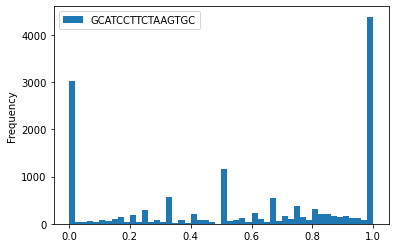

In [22]:
rad.plot.hist(bins=50)

In [23]:
combined_gene = pandas.merge(sfg, tfg, left_index=True, right_index=True, suffixes=("_star", "_cr-arc"))

# Compare cell GCATCCTTCTAAGTGC between cellranger and STAR solo gene

<ipython-input-24-3fd4f3200269>:4: RuntimeWarning: divide by zero encountered in log2
  p = numpy.log2(combined_gene).plot.scatter(x="{}_star".format(tenx_max_cell), y="{}_cr-arc".format(tenx_max_cell), ax=ax)


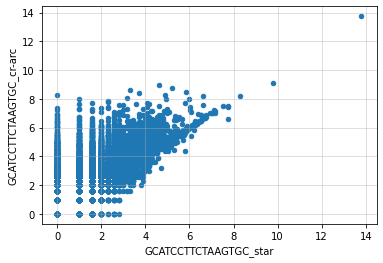

In [24]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)

p = numpy.log2(combined_gene).plot.scatter(x="{}_star".format(tenx_max_cell), y="{}_cr-arc".format(tenx_max_cell), ax=ax)
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_xlim(0,1e5)
#ax.set_ylim(0,1e5)
ax.grid(alpha=.5)

Wait a second... that looks like cell ranger has higher expression... what did they change? Are they counting introns? Multireads?

In [25]:
gene_cors = compute_spearman_anndata(tenx_common, solo279a_filtered_gene)

/usr/lib/python3/dist-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


# Compare per cell gene spearman correlation

There is a warning message from the spearman function complaining that the input matrix has an issue, so this histogram may be incorrect.

<AxesSubplot:ylabel='Frequency'>

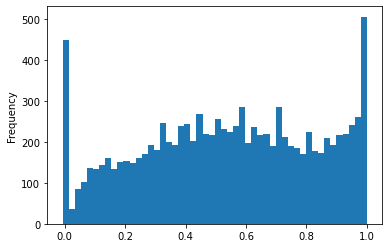

In [26]:
gene_cors.plot.hist(bins=50)

# Prepare GeneFull comparisons

In [27]:
common_genefull_barcodes = [ x for x in tenx_filtered.obs_names if x in set(tenx_filtered.obs_names).intersection(solo279a_genefull.obs_names)]
solo279a_filtered_genefull = solo279a_genefull[common_genefull_barcodes,:]
sfgf = solo279a_filtered_genefull[tenx_max_cell].to_df().T
sfgf.describe()

,GCATCCTTCTAAGTGC
count,36601.000000
mean,5.560859
std,77.401741
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,14277.000000


In [28]:
combined_genefull = pandas.merge(sfgf, tfg, left_index=True, right_index=True, suffixes=("_star", "_cr-arc"))

# Compare cell GCATCCTTCTAAGTGC between cellranger and STAR solo genefull

<ipython-input-29-1910fb9f2045>:4: RuntimeWarning: divide by zero encountered in log2
  p = numpy.log2(combined_genefull).plot.scatter(x="{}_star".format(tenx_max_cell), y="{}_cr-arc".format(tenx_max_cell), ax=ax)


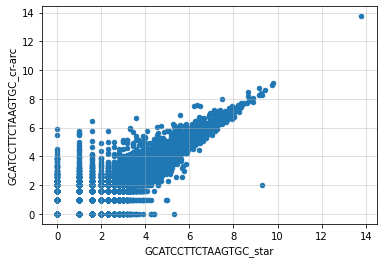

In [29]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)

p = numpy.log2(combined_genefull).plot.scatter(x="{}_star".format(tenx_max_cell), y="{}_cr-arc".format(tenx_max_cell), ax=ax)
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_xlim(0,1e5)
#ax.set_ylim(0,1e5)
ax.grid(alpha=.5)

In [32]:
tenx_common_genefull = tenx_filtered[common_genefull_barcodes,:]
genefull_cors = compute_spearman_anndata(tenx_common_genefull, solo279a_filtered_genefull)

/usr/lib/python3/dist-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


# Plot GeneFull correlations

<AxesSubplot:ylabel='Frequency'>

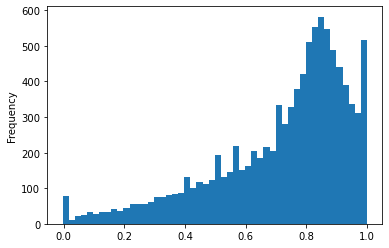

In [33]:
genefull_cors.plot.hist(bins=50)

Well that's an improvement. Looks like they're counting introns.